In [ ]:
#@title Copyright 2020 Google LLC. { display-mode: "form" }
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="http://colab.research.google.com/github/google/earthengine-community/blob/master/guides/linked/UNET_regression_demo.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/google/earthengine-community/blob/master/guides/linked/UNET_regression_demo.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# To Do

Decide a model to Use
- [x] Figure out how to extract image patches for model training
- [x] Extract Sentinel 2 and Planet Data
- [x] Figure out which type of model to use
- [x] Figure out how to run one of these scripts  

Get a Demo Notebook Running
- [x] Get the notebook running locally with the tfrecords saved locally  
- [x] Train a model with small subset of the data  
- [x] Get the model prediction and inference code to run with local files
- [x] Get a simple version of the model trained  

Modify Notebook to Run with Nightlights
- [x] Substitute NLCD with nightlights  
- [x] Retrain a simple model with the new data  

Get the Model Running on the Lab Computer
- [x] Set up a python env on the lab computer  
- [x] Set up SSH on the lab computer
- [x] Adapt script to run on lab computer
- [x] Run on lab computer  

Improve the Model 
- [x] Visualize the model accuracy by epoch
- [x] Compare a prediction to the actual image
- [ ] Visualize the distribution of nightlights values  
- [ ] Scale up the model with original image patches
- [ ] Recreate image patches in Kenya
- [ ] Substitute Landsat 8 with Sentinel 2  
- [ ] Determine hyperparameters  

If Time Allows...
- [ ] Consider running again with Planet  
- [ ] Consider running again with a ViTs
- [ ] Look wealth instead of nightlights data  
- [ ] Look at effect of dataset size on model performance

# Introduction

This is an Earth Engine <> TensorFlow notebook.  Suppose you want to predict a continuous output (regression) from a stack of continuous inputs.  In this example, the output is VIIRS Day/Night Band from [VIIRS](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG) and the input is a Landsat 8 composite.  The model is a [fully convolutional neural network (FCNN)](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf), specifically [U-net](https://arxiv.org/abs/1505.04597). In this notebook, we:

1.   Export train/test patches from Earth Engine, suitable for training an FCNN model.
2.   Preprocess the data. 
3.   Train and validating an FCNN model.
4.   Maki predictions with the trained model and import them to Earth Engine.

# Setup software libraries

Authenticate and import as necessary.

In [ ]:
# Cloud authentication when running in Colab
# Fix error: https://stackoverflow.com/questions/75666380/attributeerror-module-ipython-utils-traitlets-has-no-attribute-unicode
# from google.auth import auth
# import google
# auth.authenticate_user()

# Local authenticate when running locally
# ensure you have the Google Cloud SDK installed and configured
# !bash ~/google-cloud-sdk/bin/gcloud auth login --no-launch-browser
!~/google-cloud-sdk/bin/gsutil ls

In [ ]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

In [ ]:
# Tensorflow setup.
import tensorflow as tf
print(tf.__version__)

In [ ]:
# Folium setup.
import folium
print(folium.__version__)
# TODO substitude with geemap

# Variables

Declare the variables that will be in use throughout the notebook.

## Specify your Cloud Storage Bucket
You must have write access to a bucket to run this notebook!

In [ ]:
# Read in the .env file
from dotenv import dotenv_values

# load env variables
config = dotenv_values(".env")

# set env variables
GCS_PROJECT = config['GCS_PROJECT']
BUCKET = config['BUCKET']
HOME_PATH = config['HOME_PATH']
DATA_PATH = config['DATA_PATH']
FOLDER = config['FOLDER']


## Set other global variables

In [ ]:
# variables for image names
TRAINING_BASE = 'training_patches'
EVAL_BASE = 'eval_patches'

# Specify inputs (Landsat bands) to the model and the response variable.
opticalBands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
thermalBands = ['B10', 'B11']
BANDS = opticalBands + thermalBands
RESPONSE = 'avg_rad' ##### 
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

# Sizes of the training and evaluation datasets.
TRAIN_SIZE = 1800 # down 10X
EVAL_SIZE = 800 # down 10X

# Specify model training parameters.
BATCH_SIZE = 18
EPOCHS = 10
BUFFER_SIZE = 2000
OPTIMIZER = 'SGD'
LOSS = 'MeanSquaredError'
METRICS = ['RootMeanSquaredError']

# Create and Stack Input + Target Imagery

Gather and setup the imagery to use for inputs (predictors).  This is a three-year, cloud-free, Landsat 8 composite.  Display it in the notebook for a sanity check.

In [9]:
# Use Landsat 8 surface reflectance data.
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

# Cloud masking function.
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  mask2 = image.mask().reduce('min')
  mask3 = image.select(opticalBands).gt(0).And(
          image.select(opticalBands).lt(10000)).reduce('min')
  mask = mask1.And(mask2).And(mask3)
  return image.select(opticalBands).divide(10000).addBands(
          image.select(thermalBands).divide(10).clamp(273.15, 373.15)
            .subtract(273.15).divide(100)).updateMask(mask)

# The image input data is a cloud-masked median composite.
image = l8sr.filterDate('2021-01-01', '2022-12-31').map(maskL8sr).median()

# Use folium to visualize the imagery.
mapid = image.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[-1, 37], zoom_start=8)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)

mapid = image.getMapId({'bands': ['B10'], 'min': 0, 'max': 0.5})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='thermal',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

Prepare the response (what we want to predict).  This is nighttime brightness (in nanoWatts/sr/cm^2) from the VIIRS dataset.  Display to check.

In [11]:
viirs = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG').select('avg_rad').filterDate('2021-01-01', '2022-12-31').median()
viirs = viirs.divide(5).float() # normalize to 0-1 range

mapid = viirs.getMapId({'min': 0, 'max': 1}) # normally max 1.0
map = folium.Map(location=[-1, 37], zoom_start=8)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='viirs dnb',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

Stack the 2D images (Landsat composite and VIIRS DNB image) to create a single image from which samples can be taken.  Convert the image into an array image in which each pixel stores 256x256 patches of pixels for each band.  This is a key step that bears emphasis: to export training patches, convert a multi-band image to [an array image](https://developers.google.com/earth-engine/arrays_array_images#array-images) using [`neighborhoodToArray()`](https://developers.google.com/earth-engine/api_docs#eeimageneighborhoodtoarray), then sample the image at points.

In [12]:
featureStack = ee.Image.cat([
  image.select(BANDS),
  viirs.select(RESPONSE)
]).float()

list = ee.List.repeat(1, KERNEL_SIZE)
lists = ee.List.repeat(list, KERNEL_SIZE)
kernel = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, lists)

arrays = featureStack.neighborhoodToArray(kernel)

# Define Training and Evaluation Areas
Use some pre-made geometries to sample the stack in strategic locations.  Specifically, these are hand-made polygons in which to take the 256x256 samples.  Display the sampling polygons on a map, red for training polygons, blue for evaluation.

In [13]:
# trainingPolys = ee.FeatureCollection('projects/google/DemoTrainingGeometries')
# evalPolys = ee.FeatureCollection('projects/google/DemoEvalGeometries')
trainingPolys = ee.FeatureCollection('projects/'+GCS_PROJECT+'/assets/trainingPolys')
evalPolys = ee.FeatureCollection('projects/'+GCS_PROJECT+'/assets/evalPolys')
print(trainingPolys.getInfo())

polyImage = ee.Image(0).byte().paint(trainingPolys, 1).paint(evalPolys, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['red', 'blue']})
map = folium.Map(location=[38., -100.], zoom_start=5)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='training polygons',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

{'type': 'FeatureCollection', 'columns': {'system:index': 'String'}, 'version': 1701715229285060.0, 'id': 'projects/master-thesis-ilg/assets/trainingPolys', 'properties': {'system:asset_size': 9536}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-105.54634549357169, 39.59859906384958], [-104.74983664401647, 39.59859905890037], [-104.74983664401647, 39.95743841491241], [-105.54634549357169, 39.9574383867131], [-105.54634549357169, 39.59859906384958]]]}, 'id': '00000000000000000000', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-107.2574660979202, 34.8986595709669], [-106.46645040923522, 34.89865960553435], [-106.46645040923522, 35.38378805974467], [-107.2574660979202, 35.38378804637503], [-107.2574660979202, 34.8986595709669]]]}, 'id': '00000000000000000001', 'properties': {}}, {'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[-88.0533645328941, 41.5037437972272], [-87.17445823287098, 41

# Sampling

The mapped data look reasonable so take a sample from each polygon and merge the results into a single export.  The key step is sampling the array image at points, to get all the pixels in a 256x256 neighborhood at each point.  It's worth noting that to build the training and testing data for the FCNN, you export a single TFRecord file that contains patches of pixel values in each record.  You do NOT need to export each training/testing patch to a different image.  Since each record potentially contains a lot of data (especially with big patches or many input bands), some manual sharding of the computation is necessary to avoid the `computed value too large` error.  Specifically, the following code takes multiple (smaller) samples within each geometry, merging the results to get a single export.

In [14]:
# Convert the feature collections to lists for iteration.
trainingPolysList = trainingPolys.toList(trainingPolys.size())
evalPolysList = evalPolys.toList(evalPolys.size())

# These numbers determined experimentally.
n = 20 # Number of shards in each polygon. # formerly 200
N = 200 # Total sample size in each polygon. # formerly 2000


# Export Data to Cloud Storage
This can be modified to export to local storage, just adjust the file paths.

In [15]:

# Export all the training data (in many pieces), with one task
# per geometry.
for g in range(trainingPolys.size().getInfo()):
  geomSample = ee.FeatureCollection([])
  for i in range(n):
    sample = arrays.sample(
      region = ee.Feature(trainingPolysList.get(g)).geometry(),
      scale = 30,
      numPixels = N / n, # Size of the shard.
      seed = i,
      tileScale = 8
    )
    geomSample = geomSample.merge(sample)
  
  desc = TRAINING_BASE + '_g' + str(g)
  print(g, FOLDER, BUCKET, desc)
  
  task = ee.batch.Export.table.toCloudStorage(
    collection = geomSample,
    description = desc,
    bucket = BUCKET,
    fileNamePrefix = FOLDER + '/' + desc,
    fileFormat = 'TFRecord',
    selectors = BANDS + [RESPONSE]
  )
  task.start()
print('Training imagery tasks submitted! Check on the Tasks in GEE for their status (https://code.earthengine.google.com/tasks).')

0 unet-viirs/ csci5922-proj training_patches_g0
1 unet-viirs/ csci5922-proj training_patches_g1
2 unet-viirs/ csci5922-proj training_patches_g2
3 unet-viirs/ csci5922-proj training_patches_g3
4 unet-viirs/ csci5922-proj training_patches_g4
5 unet-viirs/ csci5922-proj training_patches_g5
6 unet-viirs/ csci5922-proj training_patches_g6
7 unet-viirs/ csci5922-proj training_patches_g7
8 unet-viirs/ csci5922-proj training_patches_g8
Training imagery tasks submitted! Check on the Tasks in GEE for their status (https://code.earthengine.google.com/tasks).


In [ ]:

# Export all the evaluation data.
for g in range(evalPolys.size().getInfo()):
  geomSample = ee.FeatureCollection([])
  for i in range(n):
    sample = arrays.sample(
      region = ee.Feature(evalPolysList.get(g)).geometry(),
      scale = 30,
      numPixels = N / n,
      seed = i,
      tileScale = 8
    )
    geomSample = geomSample.merge(sample)

  desc = EVAL_BASE + '_g' + str(g)
  print(g, FOLDER, BUCKET, desc)
  
  task = ee.batch.Export.table.toCloudStorage(
    collection = geomSample,
    description = desc,
    bucket = BUCKET,
    fileNamePrefix = FOLDER + '/' + desc,
    fileFormat = 'TFRecord',
    selectors = BANDS + [RESPONSE]
  )
  task.start()
print('Eval imagery tasks submitted! Check on the Tasks in GEE for their status (https://code.earthengine.google.com/tasks).')

# Copy Files from Cloud Storage to Local Storage
This is necessary to run the model locally. Run these here, or in the terminal to free up the Python kernel.

In [ ]:

# Copy from your bucket to local path (note -r is for recursive call)

# entire folder
# !gsutil cp -m -r gs://csci5922-proj/unet-demo /home/isly9493/csci5922/proj/data
# !gsutil -m cp -r gs://csci5922-proj/unet /home/isly9493/csci5922/proj/data
# !gsutil -m cp -r gs://csci5922-proj/unet-viirs /home/isly9493/csci5922/proj/data
!~/google-cloud-sdk/bin/gsutil -m cp -r gs://csci5922-proj/unet-viirs ~/csci5922/proj/data
# !~/google-cloud-sdk/bin/gsutil -m cp -r gs://csci5922-proj/unet-viirs /local/isly9493/csci5922/proj/data
## TODO update to user /local file path

# single file
# !gsutil cp gs://csci5922-proj/unet/training_patches_g2.tfrecord.gz /home/isly9493/csci5922/proj/data/unet/training_patches_g2.tfrecord.gz

# multiple files per gcs
# gsutil -m cp \
#   "gs://csci5922-proj/unet/eval_patches_g0.tfrecord.gz" \
#   "gs://csci5922-proj/unet/eval_patches_g1.tfrecord.gz" \
#   "gs://csci5922-proj/unet/eval_patches_g2.tfrecord.gz" \
#   "gs://csci5922-proj/unet/eval_patches_g3.tfrecord.gz" \
#   "gs://csci5922-proj/unet/training_patches_g0.tfrecord.gz" \
#   "gs://csci5922-proj/unet/training_patches_g1.tfrecord.gz" \
#   "gs://csci5922-proj/unet/training_patches_g2.tfrecord.gz" \
#   "gs://csci5922-proj/unet/training_patches_g3.tfrecord.gz" \
#   "gs://csci5922-proj/unet/training_patches_g4.tfrecord.gz" \
#   "gs://csci5922-proj/unet/training_patches_g5.tfrecord.gz" \
#   "gs://csci5922-proj/unet/training_patches_g6.tfrecord.gz" \
#   "gs://csci5922-proj/unet/training_patches_g7.tfrecord.gz" \
#   "gs://csci5922-proj/unet/training_patches_g8.tfrecord.gz" \
#   .

# move data to data folder
# !mv ~/csci5922/proj/data/unet-viirs /local/isly9493/csci5922/proj/data


# Training data

Load the data exported from Earth Engine into a `tf.data.Dataset`.  The following are helper functions for that.

In [16]:
# from google.cloud import storage

def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  return tf.io.parse_single_example(example_proto, FEATURES_DICT)


def to_tuple(inputs):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tuple of (inputs, outputs).
  """
  inputsList = [inputs.get(key) for key in FEATURES]
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  return stacked[:,:,:len(BANDS)], stacked[:,:,len(BANDS):]


def get_dataset(path, prefix, n_files):
  """Function to read, parse and format to tuple a set of input tfrecord files.
  Get all the files matching the pattern, parse and convert to tuple.
  Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
  Returns:
    A tf.data.Dataset
  """
  # original code
  # glob = tf.io.gfile.glob(pattern)
  
  # from the cloud
  # https://cloud.google.com/appengine/docs/legacy/standard/python/googlecloudstorageclient/read-write-to-cloud-storage
  # storage_client = storage.Client()
  # bucket = storage_client.get_bucket(BUCKET)
  # blobs = storage_client.list_blobs(BUCKET, prefix=pattern)
  # glob = []
  # for blob in blobs:
  #   globs.append(blob.name)
  # print(globs)
  # # append bucket name to globs
  # glob = ['gs://' + BUCKET + '/' + f for f in globs]

  # read local tfrecord.gz files from unet-mini
  glob = []
  for i in range(0, n_files):
    glob = path + prefix + '_g' + str(i) + '.tfrecord.gz'

  # glob = [
  #   '/home/isly9493/csci5922/proj/data/unet-mini/eval_patches_g0.tfrecord.gz',
  #   '/home/isly9493/csci5922/proj/data/unet-mini/eval_patches_g1.tfrecord.gz'
  # ]
  dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
  dataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  dataset = dataset.map(to_tuple, num_parallel_calls=5)
  return dataset

Use the helpers to read in the training dataset.  Print the first record to check.

In [24]:
# import os
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/ilyonsg/.config/gcloud/application_default_credentials.json"

def get_training_dataset():
	"""Get the preprocessed training dataset
  Returns:
    A tf.data.Dataset of training data.
  """
	# glob = 'gs://' + BUCKET + '/' + FOLDER + '/' + TRAINING_BASE + '*'
	dataset = get_dataset(HOME_PATH + DATA_PATH, TRAINING_BASE, 9)
	dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
	return dataset

training = get_training_dataset()

# print(iter(training.take(1)).next())

# Evaluation data

Now do the same thing to get an evaluation dataset.  Note that unlike the training dataset, the evaluation dataset has a batch size of 1, is not repeated and is not shuffled.

TODO: troubleshoot auth for cloud storage access, OR save things locally. 

In [25]:
def get_eval_dataset():
	"""Get the preprocessed evaluation dataset
  Returns:
    A tf.data.Dataset of evaluation data.
  """
	# glob = 'gs://' + BUCKET + '/' + FOLDER + '/' + EVAL_BASE + '*'
	
	dataset = get_dataset(HOME_PATH + DATA_PATH, EVAL_BASE, 4)
	dataset = dataset.batch(1).repeat()
	return dataset

evaluation = get_eval_dataset()

# print(iter(evaluation.take(1)).next())

# Model

Here we use the Keras implementation of the U-Net model.  The U-Net model takes 256x256 pixel patches as input and outputs per-pixel class probability, label or a continuous output.  We can implement the model essentially unmodified, but will use mean squared error loss on the sigmoidal output since we are treating this as a regression problem, rather than a classification problem.  Since impervious surface fraction is constrained to [0,1], with many values close to zero or one, a saturating activation function is suitable here.

In [21]:
from tensorflow import keras
from keras import layers
from keras import losses
from keras import models
from keras import metrics
from keras import optimizers

keras.backend.clear_session()

def conv_block(input_tensor, num_filters):
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
	encoder = layers.BatchNormalization()(encoder)
	encoder = layers.Activation('relu')(encoder)
	return encoder

def encoder_block(input_tensor, num_filters):
	encoder = conv_block(input_tensor, num_filters)
	encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
	return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
	decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
	decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
	decoder = layers.BatchNormalization()(decoder)
	decoder = layers.Activation('relu')(decoder)
	return decoder

def get_model():
	inputs = layers.Input(shape=[None, None, len(BANDS)]) # 256
	encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128
	encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
	encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
	encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
	encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
	center = conv_block(encoder4_pool, 1024) # center
	decoder4 = decoder_block(center, encoder4, 512) # 16
	decoder3 = decoder_block(decoder4, encoder3, 256) # 32
	decoder2 = decoder_block(decoder3, encoder2, 128) # 64
	decoder1 = decoder_block(decoder2, encoder1, 64) # 128
	decoder0 = decoder_block(decoder1, encoder0, 32) # 256
	outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

	model = models.Model(inputs=[inputs], outputs=[outputs])

	model.compile(
		optimizer=optimizers.get(OPTIMIZER),
		loss=losses.get(LOSS),
		metrics=[metrics.get(metric) for metric in METRICS])

	return model

# Training the model

You train a Keras model by calling `.fit()` on it.  Here we're going to train for 10 epochs, which is suitable for demonstration purposes.  For production use, you probably want to optimize this parameter, for example through [hyperparamter tuning](https://cloud.google.com/ml-engine/docs/tensorflow/using-hyperparameter-tuning).

In [22]:
m = get_model()

Fit the model.

In [26]:
# fit the model
history = m.fit(
    x=training,
    epochs=10,
    # epochs=EPOCHS,
    steps_per_epoch=int(TRAIN_SIZE / BATCH_SIZE),
    validation_data=evaluation,
    validation_steps=EVAL_SIZE
)
## ONLY 180 SECONDS TO TRAIN 10 EPOCHS LET'S GO!

Epoch 1/10


2023-12-08 16:10:21.370201: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-08 16:10:21.429647: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-12-08 16:10:21.431626: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-12-08 16:10:21.431647: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2023-12-08 16:10:21.431749: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-12-08 16:10

  2/100 [..............................] - ETA: 12s - loss: 0.2011 - root_mean_squared_error: 0.4485  

2023-12-08 16:10:33.423932: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



100/100 [==============================] - 37s 237ms/step - loss: 0.1304 - root_mean_squared_error: 0.3611 - val_loss: 0.1391 - val_root_mean_squared_error: 0.3730
Epoch 2/10
100/100 [==============================] - 16s 164ms/step - loss: 0.0840 - root_mean_squared_error: 0.2898 - val_loss: 0.1109 - val_root_mean_squared_error: 0.3330
Epoch 3/10
100/100 [==============================] - 16s 164ms/step - loss: 0.0746 - root_mean_squared_error: 0.2732 - val_loss: 0.0825 - val_root_mean_squared_error: 0.2872
Epoch 4/10
100/100 [==============================] - 17s 166ms/step - loss: 0.0701 - root_mean_squared_error: 0.2648 - val_loss: 0.0633 - val_root_mean_squared_error: 0.2515
Epoch 5/10
100/100 [==============================] - 17s 166ms/step - loss: 0.0667 - root_mean_squared_error: 0.2583 - val_loss: 0.0498 - val_root_mean_squared_error: 0.2232
Epoch 6/10
100/100 [==============================] - 16s 165ms/step - loss: 0.0641 - root_mean_squared_error: 0.2532 - val_loss: 0.0438

In [ ]:
# save the model to a local file 
m.save('./data/unet-viirs/unet_viirs_e10.h5')

Note that the notebook VM is sometimes not heavy-duty enough to get through a whole training job, especially if you have a large buffer size or a large number of epochs.  You can still use this notebook for training, but may need to set up an alternative VM ([learn more](https://research.google.com/colaboratory/local-runtimes.html)) for production use.  Alternatively, you can package your code for running large training jobs on Google's AI Platform [as described here](https://cloud.google.com/ml-engine/docs/tensorflow/trainer-considerations).  The following code loads a pre-trained model, which you can use for predictions right away.

In [17]:
# import os
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/ilyonsg/.config/gcloud/application_default_credentials.json"
# Load a trained model. 50 epochs. 25 hours. Final RMSE ~0.08.


# MODEL_DIR = 'gs://ee-docs-demos/fcnn-demo/trainer/model'
m = tf.keras.models.load_model('./data/unet-viirs/unet_viirs_e10.h5')
m.summary()

2023-12-08 16:06:51.118873: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 16:06:51.119040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 16:06:51.137471: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 9)]      0         []                            
                                                                                                  
 conv2d_46 (Conv2D)          (None, None, None, 32)       2624      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_54 (Ba  (None, None, None, 32)       128       ['conv2d_46[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_54 (Activation)  (None, None, None, 32)       0         ['batch_normalization_54

# Evaluation
Let's look at how the model performed in terms of loss while it trained.

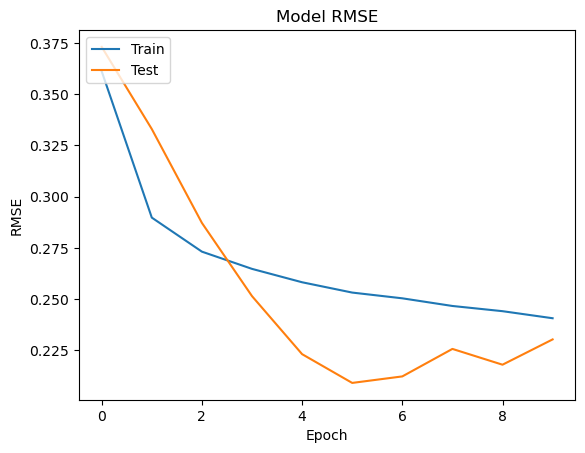

In [32]:
# plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Prediction

The prediction pipeline is:

1.  Export imagery on which to do predictions from Earth Engine in TFRecord format to a Cloud Storage bucket.
2.  Use the trained model to make the predictions.
3.  Write the predictions to a TFRecord file in a Cloud Storage.
4.  Upload the predictions TFRecord file to Earth Engine.

The following functions handle this process.  It's useful to separate the export from the predictions so that you can experiment with different models without running the export every time.

## Export Sample Imagery for Prediction

In [ ]:
def doExport(out_image_base, kernel_buffer, region):
  """Run the image export task.  Block until complete.
  """
  task = ee.batch.Export.image.toCloudStorage(
    image = image.select(BANDS),
    description = out_image_base,
    bucket = BUCKET,
    fileNamePrefix = FOLDER + '/' + out_image_base,
    region = region.getInfo()['coordinates'],
    scale = 30,
    fileFormat = 'TFRecord',
    maxPixels = 1e10,
    formatOptions = {
      'patchDimensions': KERNEL_SHAPE,
      'kernelSize': kernel_buffer,
      'compressed': True,
      'maxFileSize': 104857600
    }
  )
  task.start()

  # Block until the task completes.
  print('Running image export to Cloud Storage...')
  import time
  while task.active():
    time.sleep(30)

  # Error condition
  if task.status()['state'] != 'COMPLETED':
    print('Error with image export.')
  else:
    print('Image export completed.')

## Define Code for Running Model on Prediction Data
Modified to run on local data.

In [ ]:
def doPrediction(out_image_base, kernel_buffer):
  """Perform inference on exported imagery, upload to Earth Engine.
  """

  print('Looking for TFRecord files...')

  # # Get a list of all the files in the output bucket.
  # filesList = !gsutil ls 'gs://'{BUCKET}'/'{FOLDER}
  # Get a list of all local files in /data/unet-mini
  filesList = !ls '/home/isly9493/csci5922/proj/data/unet-viirs/'

  # Get only the files generated by the image export.
  exportFilesList = [s for s in filesList if out_image_base in s]

  # Get the list of image files and the JSON mixer file.
  imageFilesList = []
  jsonFile = None
  for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      jsonFile = f

  # Make sure the files are in the right order.
  imageFilesList.sort()

  from pprint import pprint
  pprint(imageFilesList)
  print('here I am')
  print(jsonFile)

  import json
  # Load the contents of the mixer file to a JSON object.
  # jsonText = !gsutil cat {jsonFile}  
  jsonText = !cat '/home/isly9493/csci5922/proj/data/unet-viirs/FCNN_demo_beijing_384_mixer.json'
  print(jsonText)
  # Get a single string w/ newlines from the IPython.utils.text.SList
  mixer = json.loads(jsonText.nlstr)
  pprint(mixer)
  patches = mixer['totalPatches']



  buffered_shape = [
      KERNEL_SHAPE[0] + kernel_buffer[0],
      KERNEL_SHAPE[1] + kernel_buffer[1]]

  imageColumns = [
    tf.io.FixedLenFeature(shape=buffered_shape, dtype=tf.float32)
      for k in BANDS
  ]

  imageFeaturesDict = dict(zip(BANDS, imageColumns))

  def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, imageFeaturesDict)

  def toTupleImage(inputs):
    inputsList = [inputs.get(key) for key in BANDS]
    stacked = tf.stack(inputsList, axis=0)
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked

  # append absolute path to imageFilesList
  imageFilesList = [HOME_PATH + DATA_PATH + f for f in imageFilesList]
  print(imageFilesList)
  
  # Create a dataset from the TFRecord file(s) in Cloud Storage.
  imageDataset = tf.data.TFRecordDataset(imageFilesList, compression_type='GZIP')
  imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)
  imageDataset = imageDataset.map(toTupleImage).batch(1)

  # print(imageDataset)

  # Perform inference.
  print('Running predictions...')
  predictions = m.predict(imageDataset, steps=patches, verbose=1)
  # print(predictions[0])
  return predictions

In [ ]:

def writePredictions(predictions, out_image_base, kernel_buffer):
  print('Writing predictions...')
  out_image_file = 'gs://' + BUCKET + '/' + FOLDER + out_image_base + '.TFRecord'
  # out_image_file = '/home/isly9493/csci5922/proj/data/unet-mini/' + out_image_base + '.TFRecord'

  # Get set up for prediction.
  x_buffer = int(kernel_buffer[0] / 2)
  y_buffer = int(kernel_buffer[1] / 2)
  
  
  writer = tf.io.TFRecordWriter(out_image_file)
  patches = 0
  for predictionPatch in predictions:
    print('Writing patch ' + str(patches) + '...')
    predictionPatch = predictionPatch[
        x_buffer:x_buffer+KERNEL_SIZE, y_buffer:y_buffer+KERNEL_SIZE]

    # Create an example.
    example = tf.train.Example(
      features=tf.train.Features(
        feature={
          'impervious': tf.train.Feature(
            float_list=tf.train.FloatList(
              value=predictionPatch.flatten()
            )
          )
        }
      )
    )
    # Write the example.
    writer.write(example.SerializeToString())
    patches += 1

  print('Done for looping.')
  writer.close()


In [ ]:
def uploadPredictionsToEE(out_image_base, user_folder):
  # Start the upload.
  print('Uploading to Google Earth Egnine...')
  
  # define file paths
  out_image_file = 'gs://' + BUCKET + '/' + FOLDER + '/' + out_image_base + '.TFRecord'
  out_image_asset = user_folder + '/' + out_image_base
  jsonFile = 'gs://' + BUCKET + '/' + FOLDER + '/' + 'FCNN_demo_beijing_384_mixer.json'
  # jsonFile = '/home/isly9493/csci5922/proj/data/unet-mini/FCNN_demo_beijing_384_mixer.json'
  
  print('out_image_asset: ', out_image_asset)
  print('out_image_file: ', out_image_file)
  print('jsonFile: ', jsonFile)
  
  # upload file to google earth engine from gcs
  # !earthengine upload image --asset_id={out_image_asset} {out_image_file} {jsonFile}
  !earthengine upload image --asset_id={out_image_asset} {out_image_file} {jsonFile}

Now there's all the code needed to run the prediction pipeline, all that remains is to specify the output region in which to do the prediction, the names of the output files, where to put them, and the shape of the outputs.  In terms of the shape, the model is trained on 256x256 patches, but can work (in theory) on any patch that's big enough with even dimensions ([reference](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf)).  Because of tile boundary artifacts, give the model slightly larger patches for prediction, then clip out the middle 256x256 patch.  This is controlled with a kernel buffer, half the size of which will extend beyond the kernel buffer.  For example, specifying a 128x128 kernel will append 64 pixels on each side of the patch, to ensure that the pixels in the output are taken from inputs completely covered by the kernel.

### Specify Region and Outputs for Prediction

In [30]:
# Output assets folder: YOUR FOLDER
user_folder = 'projects/'+GCS_PROJECT+'/assets' # INSERT YOUR FOLDER HERE.

# Base file name to use for TFRecord files and assets.
bj_image_base = 'FCNN_demo_beijing_384_'
# Half this will extend on the sides of each patch.
bj_kernel_buffer = [128, 128]
# Beijing
bj_region = ee.Geometry.Polygon(
        [[[115.9662455210937, 40.121362012835235],
          [115.9662455210937, 39.64293313749715],
          [117.01818643906245, 39.64293313749715],
          [117.01818643906245, 40.121362012835235]]], None, False)

In [ ]:
# Run the export.
doExport(bj_image_base, bj_kernel_buffer, bj_region)

In [ ]:
# copy the file from cloud storage to local
!gsutil -m cp \
  "gs://csci5922-proj/unet/FCNN_demo_beijing_384_00000.tfrecord.gz" \
  "gs://csci5922-proj/unet/FCNN_demo_beijing_384_00001.tfrecord.gz" \
  "gs://csci5922-proj/unet/FCNN_demo_beijing_384_00002.tfrecord.gz" \
  "gs://csci5922-proj/unet/FCNN_demo_beijing_384_00003.tfrecord.gz" \
  "gs://csci5922-proj/unet/FCNN_demo_beijing_384_00004.tfrecord.gz" \
  "gs://csci5922-proj/unet/FCNN_demo_beijing_384_mixer.json" \
  "/home/isly9493/csci5922/proj/data/unet-mini"


In [ ]:
# Run the prediction.
predictions = doPrediction(bj_image_base, bj_kernel_buffer)


In [ ]:
# Write the predictions.
writePredictions(predictions, bj_image_base, bj_kernel_buffer)

In [ ]:
# upload to earth engine
uploadPredictionsToEE(bj_image_base, user_folder)

# Display the output

One the data has been exported, the model has made predictions and the predictions have been written to a file, and the image imported to Earth Engine, it's possible to display the resultant Earth Engine asset.  Here, display the impervious area predictions over Beijing, China.

In [43]:
map = folium.Map(location=[39.898, 116.5097], zoom_start=11)

# actual viirs
viirs = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG').select('avg_rad').filterDate('2021-01-01', '2022-12-31').median().divide(60).float()
actual_image = viirs.clip(bj_region)
mapid = viirs.getMapId({'min': 0, 'max': 1}) # normally max 1.0
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='viirs dnb',
  ).add_to(map)

# prediction
out_image = ee.Image(user_folder + '/' + bj_image_base)
mapid = out_image.getMapId({'min': 0, 'max': 1})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='predicted nightlights',
  ).add_to(map)


# difference
diff = out_image.subtract(actual_image)
mapid = diff.getMapId({'min': -0.5, 'max': 0.5, 'palette': ['FF0000', '000000', '00FF00']})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='difference',
  ).add_to(map)

# visualize the map
map.add_child(folium.LayerControl())
map